In [1]:
# Import Library
import os, random, time, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from skimage import feature

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2

In [2]:
# Akses Googel Drive (Google COllab)
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/CV_CIFAR100_peliks"
os.makedirs(drive_path, exist_ok=True)


Mounted at /content/drive


In [4]:
# Config
USE_COARSE = True
NUM_CLASSES = 20
PCA_COMPONENTS = 300
VAL_SIZE = 0.1
RESNET_BATCH = 128
IMG_SIZE = 224
SEED = 42
REG_STRENGTH = 1e-4

# Seeds for reproducibility
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [5]:
# Download dataset CIFAR-100 dari tensorflow
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')
y_train = y_train.flatten()
y_test = y_test.flatten()

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)


In [6]:
# Preprocessing Grayscale & Blur
def low_level_processing(images):
    out = np.empty((images.shape[0], 32, 32), dtype=np.float32)
    for i in range(images.shape[0]):
        gray = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        norm = cv2.normalize(blur, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        out[i] = norm
    return out

X_train_low = low_level_processing(X_train)
X_test_low  = low_level_processing(X_test)
print("X train, X test:", X_train_low.shape, X_test_low.shape)


X train, X test: (50000, 32, 32) (10000, 32, 32)


In [7]:
# Manual feature extraction menggunakan (HOG, LBP, HSV Color)
def hog_features(gray_img):
    return feature.hog(gray_img, orientations=9, pixels_per_cell=(8,8),
                       cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)

def lbp_hist(gray_img, P=8, R=1):
    lbp = feature.local_binary_pattern(gray_img, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-6)
    return hist

def color_hist_hsv(rgb_img, bins=(8,8,8)):
    hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, list(bins), [0,180,0,256,0,256])
    return cv2.normalize(hist, None).flatten().astype("float32")

def extract_manual_features(X_rgb, X_gray):
    feats = []
    for i in tqdm(range(X_rgb.shape[0]), desc="Manual features", unit="img"):
        feats.append(np.hstack([
            hog_features(X_gray[i]),
            lbp_hist(X_gray[i]),
            color_hist_hsv(X_rgb[i])
        ]))
    return np.array(feats, dtype=np.float32)

print("manual features extraction: ")
X_train_manual = extract_manual_features(X_train, X_train_low)
X_test_manual  = extract_manual_features(X_test,  X_test_low)
print("\nManual features:", X_train_manual.shape, X_test_manual.shape)



manual features extraction: 


Manual features:   0%|          | 0/50000 [00:00<?, ?img/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
Manual features: 100%|██████████| 10000/10000 [00:08<00:00, 1125.61img/s]


Manual features: (50000, 846) (10000, 846)


In [8]:
# Deep learning feature extraction menggunakan (ResNet50)
base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
resnet_model = Model(inputs=base.input, outputs=base.output)
resnet_model.trainable = False

def resize_and_preprocess(batch_rgb):
    out = np.empty((batch_rgb.shape[0], IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    for i in range(batch_rgb.shape[0]):
        out[i] = cv2.resize(batch_rgb[i], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    return preprocess_input(out.astype(np.float32))

def extract_resnet_embeddings(X, batch_size=RESNET_BATCH):
    n = X.shape[0]
    embs = []
    for start in tqdm(range(0, n, batch_size), desc="ResNet embeddings", unit="batch"):
        end = min(start + batch_size, n)
        batch = resize_and_preprocess(X[start:end])
        emb = resnet_model.predict(batch, verbose=0)
        embs.append(emb)
    return np.vstack(embs).astype(np.float32)

print("Extracting ResNet50 features:")
X_train_res = extract_resnet_embeddings(X_train)
X_test_res  = extract_resnet_embeddings(X_test)
print("\nResNet features:", X_train_res.shape, X_test_res.shape)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Extracting ResNet50 features:


ResNet embeddings: 100%|██████████| 79/79 [00:23<00:00,  3.36batch/s]


ResNet features: (50000, 2048) (10000, 2048)


In [9]:
# Membuat model MLP yang akan mengklasifikasikan gambar berdasarkan hasil feature extracion

results = {}

y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat  = to_categorical(y_test, NUM_CLASSES)

def build_mlp_model(input_dim, name="mlp"):
    model = Sequential(name=name)
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(REG_STRENGTH)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(REG_STRENGTH)))
    model.add(Dropout(0.2))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# cek
model = build_mlp_model(X_train_manual.shape[1])
model.summary()

Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       108,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,972 (460.83 KB)

 Trainable params: 117,972 (460.83 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Early Stopping
callbacks = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [11]:
# Manual Feature Extraction Only

X_train_man_raw, X_val_man_raw, y_train_manual, y_val_manual = train_test_split(
    X_train_manual,
    y_train_cat,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=y_train
)

scaler_manual = StandardScaler()
X_train_man_std = scaler_manual.fit_transform(X_train_man_raw)
X_val_man_std   = scaler_manual.transform(X_val_man_raw)
X_test_man_std  = scaler_manual.transform(X_test_manual)

model_manual = build_mlp_model(X_train_man_std.shape[1], name="Manual_Model")

hist_manual = model_manual.fit(
    X_train_man_std, y_train_manual,
    validation_data=(X_val_man_std, y_val_manual),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

loss_manual, acc_manual = model_manual.evaluate(X_test_man_std, y_test_cat, verbose=0)
results['Manual Only'] = acc_manual
print(f"Test Accuracy (Manual Only): {acc_manual:.4f}")


Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.1715 - loss: 2.8737 - val_accuracy: 0.3370 - val_loss: 2.2256
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3177 - loss: 2.2730 - val_accuracy: 0.3704 - val_loss: 2.0976
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3562 - loss: 2.1301 - val_accuracy: 0.3920 - val_loss: 2.0344
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3817 - loss: 2.0408 - val_accuracy: 0.3956 - val_loss: 2.0040
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3963 - loss: 1.9824 - val_accuracy: 0.3988 - val_loss: 1.9875
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4094 - loss: 1.9443 - val_accuracy: 0.3998 - val_loss: 1.9789
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4182 - loss: 1.9067 - val_accuracy: 0.4066 - val_loss: 1.9652
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4328 - loss: 1.8647 - val_ac

In [12]:
# ResNet Feature Extraction Only

X_train_res_raw, X_val_res_raw, y_tr_r, y_val_r = train_test_split(
    X_train_res,
    y_train_cat,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=y_train
)

scaler_res = StandardScaler()
X_tr_res_std   = scaler_res.fit_transform(X_train_res_raw)
X_val_res_std  = scaler_res.transform(X_val_res_raw)
X_test_res_std = scaler_res.transform(X_test_res)

pca_res = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
X_tr_r = pca_res.fit_transform(X_tr_res_std)
X_val_r = pca_res.transform(X_val_res_std)
X_test_res_pca = pca_res.transform(X_test_res_std)

model_resnet_mlp = build_mlp_model(X_tr_r.shape[1], name="ResNet_Model")
hist_resnet = model_resnet_mlp.fit(
    X_tr_r, y_tr_r,
    validation_data=(X_val_r, y_val_r),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

loss_res, acc_res = model_resnet_mlp.evaluate(X_test_res_pca, y_test_cat, verbose=0)
results['ResNet Only'] = acc_res
print(f"Test Accuracy (ResNet Only): {acc_res:.4f}")


Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3214 - loss: 2.7379 - val_accuracy: 0.7224 - val_loss: 0.9044
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6700 - loss: 1.0839 - val_accuracy: 0.7640 - val_loss: 0.7772
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7249 - loss: 0.9036 - val_accuracy: 0.7778 - val_loss: 0.7271
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7506 - loss: 0.8158 - val_accuracy: 0.7862 - val_loss: 0.7024
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7689 - loss: 0.7618 - val_accuracy: 0.7890 - val_loss: 0.6934
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7808 - loss: 0.7244 - val_accuracy: 0.7948 - val_loss: 0.6830
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7870 - loss: 0.7021 - val_accuracy: 0.7968 - val_loss: 0.6761
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7927 - loss: 0.6707 - val_acc

In [13]:
# Hybrid Feature Extraction

idx_all = np.arange(X_train_manual.shape[0])

idx_train, idx_val, y_tr_h, y_val_h = train_test_split(
    idx_all,
    y_train_cat,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=y_train
)

X_train_man_raw = X_train_manual[idx_train]
X_val_man_raw   = X_train_manual[idx_val]

X_train_res_raw = X_train_res[idx_train]
X_val_res_raw   = X_train_res[idx_val]

scaler_h_man = StandardScaler()
X_tr_man_std  = scaler_h_man.fit_transform(X_train_man_raw)
X_val_man_std = scaler_h_man.transform(X_val_man_raw)
X_test_man_h  = scaler_h_man.transform(X_test_manual)

scaler_h_res = StandardScaler()
X_tr_res_std  = scaler_h_res.fit_transform(X_train_res_raw)
X_val_res_std = scaler_h_res.transform(X_val_res_raw)
X_test_res_h  = scaler_h_res.transform(X_test_res)

# concatenate 50% dari manual feature dan 100% dari resnet feature
X_tr_fused   = np.hstack([0.5 * X_tr_man_std,  1.0 * X_tr_res_std])
X_val_fused  = np.hstack([0.5 * X_val_man_std, 1.0 * X_val_res_std])
X_test_fused = np.hstack([0.5 * X_test_man_h,  1.0 * X_test_res_h])

print(f"Fused Shape Before PCA (train): {X_tr_fused.shape}")

pca_hybrid = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
X_tr_h = pca_hybrid.fit_transform(X_tr_fused)
X_val_h = pca_hybrid.transform(X_val_fused)
X_test_hybrid = pca_hybrid.transform(X_test_fused)

model_hybrid = build_mlp_model(X_tr_h.shape[1], name="Hybrid_Model")
hist_hybrid = model_hybrid.fit(
    X_tr_h, y_tr_h,
    validation_data=(X_val_h, y_val_h),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

loss_hybrid, acc_hybrid = model_hybrid.evaluate(X_test_hybrid, y_test_cat, verbose=0)
results['Hybrid Fusion'] = acc_hybrid
print(f"Test Accuracy (Hybrid Fusion): {acc_hybrid:.4f}")


Fused Shape Before PCA (train): (45000, 2894)
Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2954 - loss: 3.1208 - val_accuracy: 0.7134 - val_loss: 0.9455
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6597 - loss: 1.1278 - val_accuracy: 0.7610 - val_loss: 0.7916
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7181 - loss: 0.9340 - val_accuracy: 0.7770 - val_loss: 0.7329
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7445 - loss: 0.8302 - val_accuracy: 0.7830 - val_loss: 0.7131
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7641 - loss: 0.7678 - val_accuracy: 0.7946 - val_loss: 0.6927
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7757 - loss: 0.7299 - val_accuracy: 0.7916 - val_loss: 0.6837
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7829 - loss: 0.7071 - val_accuracy: 0.7970 - val_loss: 0.6712
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

In [14]:
# Plotting acc/loss

def plot_history(history, title="Training History"):
    plt.figure(figsize=(16,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()


In [18]:
# Plotting confussion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}',ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [26]:
# classification report + print sekaligus utnuk confusion matrix
def plot_report_matrix(model, X_test, y_test_cat, title="Model Evaluation"):
    y_true = np.argmax(y_test_cat, axis=1)

    # Predict
    y_pred = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)

    # Report
    print(f"\n{title}")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = [str(i) for i in range(NUM_CLASSES)]

    plot_confusion_matrix(cm, classes, title=f"{title} - Confusion Matrix")


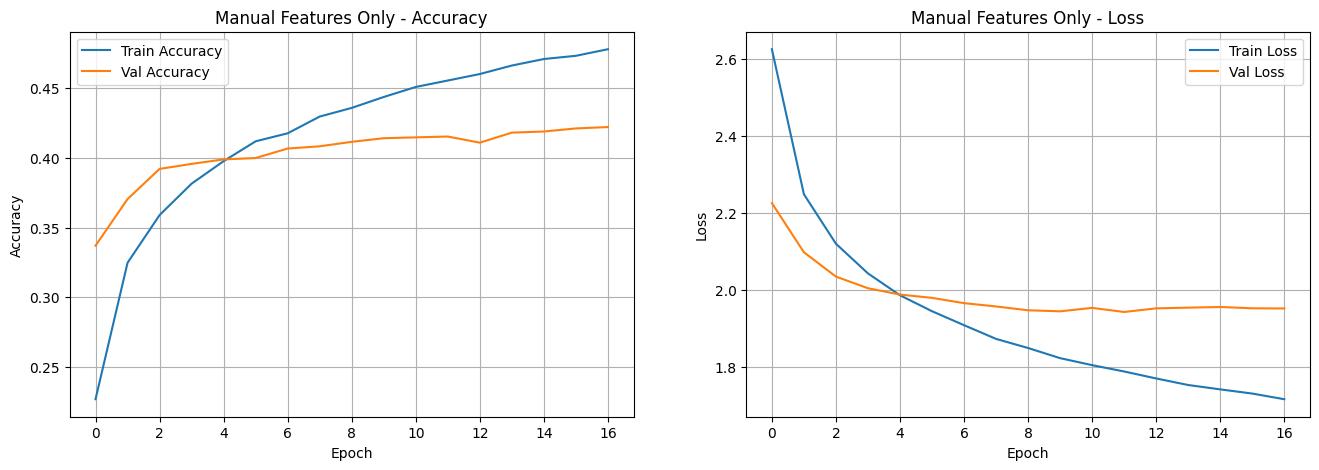


Manual Features Only
              precision    recall  f1-score   support

           0       0.37      0.31      0.34       500
           1       0.35      0.38      0.36       500
           2       0.57      0.65      0.61       500
           3       0.54      0.47      0.50       500
           4       0.54      0.48      0.51       500
           5       0.45      0.45      0.45       500
           6       0.55      0.57      0.56       500
           7       0.37      0.41      0.39       500
           8       0.29      0.37      0.33       500
           9       0.48      0.52      0.50       500
          10       0.57      0.57      0.57       500
          11       0.35      0.29      0.32       500
          12       0.30      0.33      0.31       500
          13       0.24      0.11      0.15       500
          14       0.37      0.52      0.43       500
          15       0.27      0.25      0.26       500
          16       0.23      0.19      0.21       500
     

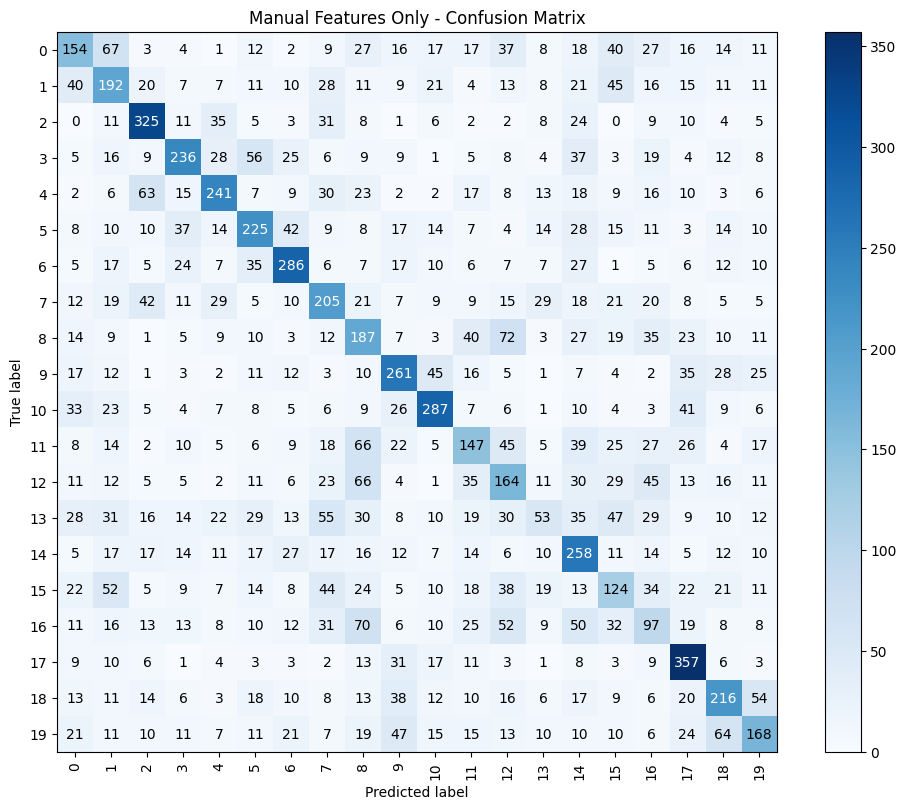

In [28]:
plot_history(hist_manual, "Manual Features Only")
plot_report_matrix(model_manual, X_test_man_std, y_test_cat, "Manual Features Only")


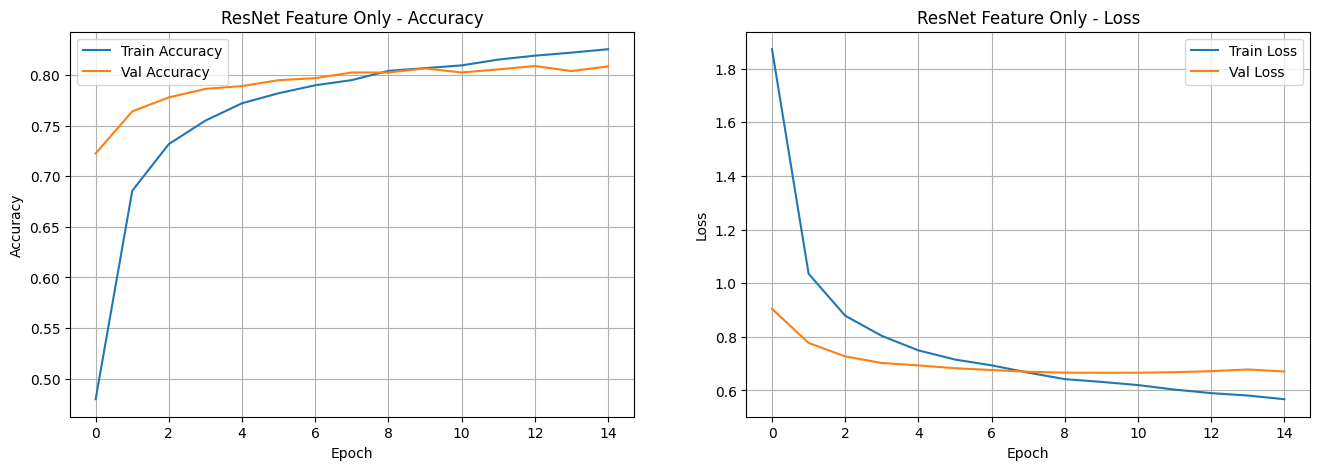


ResNet Features Only
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       500
           1       0.75      0.78      0.76       500
           2       0.88      0.91      0.90       500
           3       0.92      0.83      0.87       500
           4       0.88      0.88      0.88       500
           5       0.82      0.88      0.85       500
           6       0.89      0.88      0.89       500
           7       0.80      0.77      0.79       500
           8       0.72      0.76      0.74       500
           9       0.82      0.86      0.84       500
          10       0.89      0.85      0.87       500
          11       0.79      0.74      0.76       500
          12       0.73      0.63      0.67       500
          13       0.71      0.74      0.73       500
          14       0.89      0.91      0.90       500
          15       0.67      0.66      0.67       500
          16       0.61      0.72      0.66       500
     

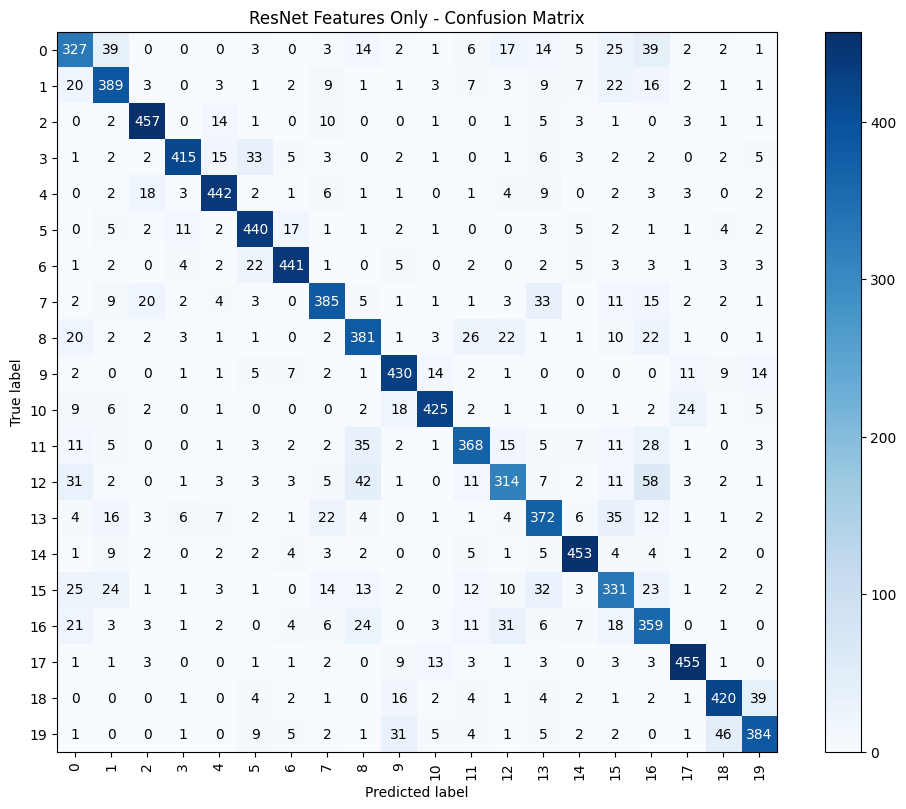

In [29]:
plot_history(hist_resnet, "ResNet Feature Only")
plot_report_matrix(model_resnet_mlp, X_test_res_pca, y_test_cat, "ResNet Features Only")


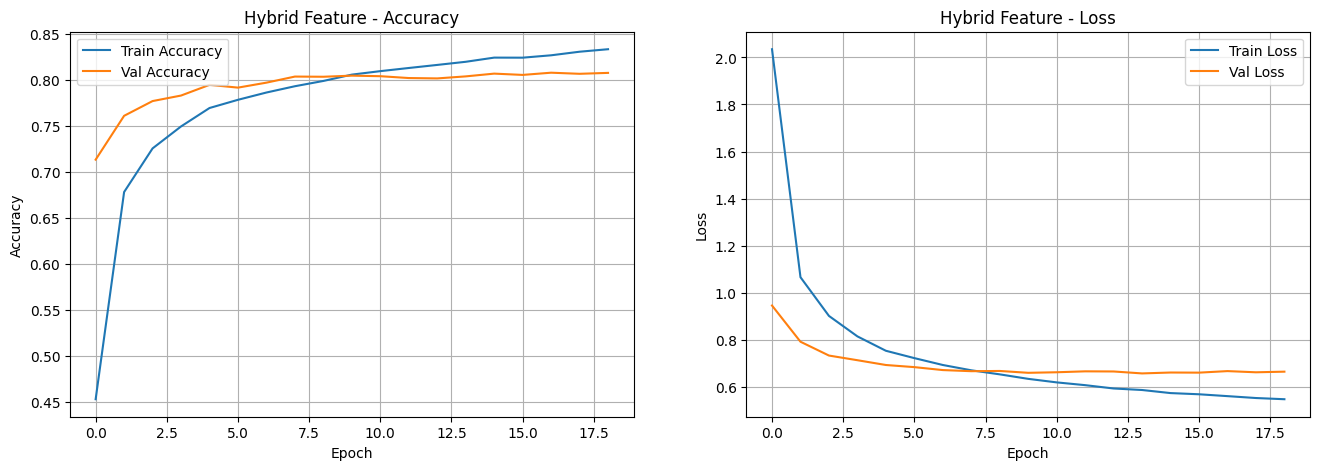


Hybrid Feature
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       500
           1       0.77      0.75      0.76       500
           2       0.88      0.92      0.90       500
           3       0.91      0.81      0.86       500
           4       0.90      0.87      0.88       500
           5       0.82      0.87      0.84       500
           6       0.87      0.89      0.88       500
           7       0.82      0.77      0.79       500
           8       0.76      0.75      0.76       500
           9       0.85      0.87      0.86       500
          10       0.86      0.86      0.86       500
          11       0.77      0.77      0.77       500
          12       0.75      0.62      0.68       500
          13       0.70      0.73      0.71       500
          14       0.87      0.91      0.89       500
          15       0.66      0.69      0.68       500
          16       0.63      0.74      0.68       500
          1

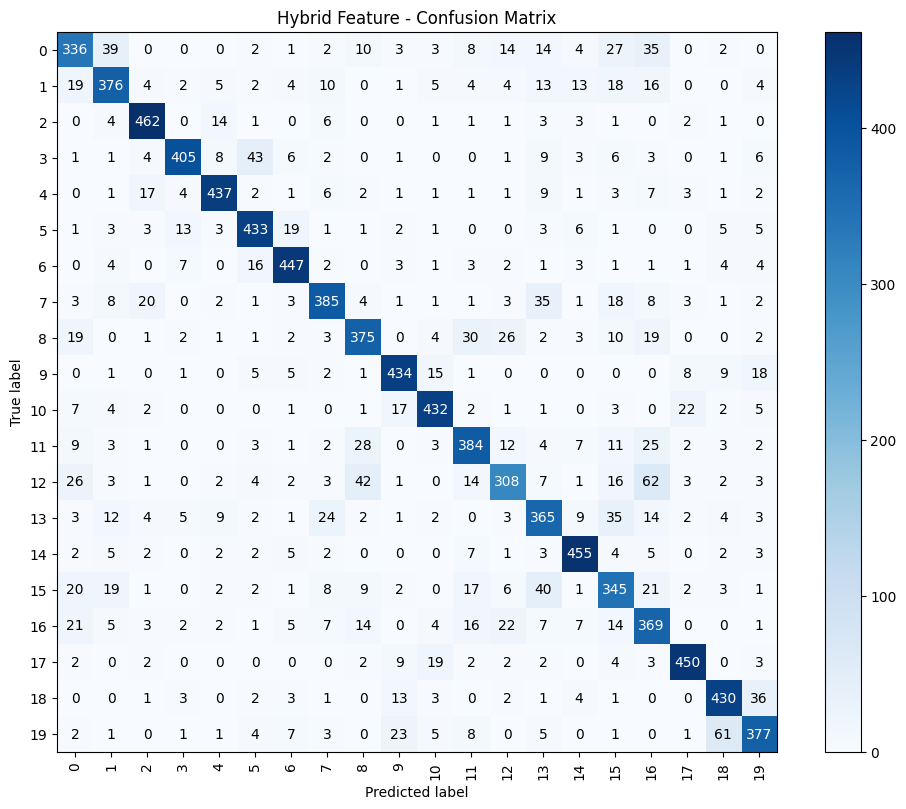

In [30]:
plot_history(hist_hybrid, "Hybrid Feature")
plot_report_matrix(model_hybrid, X_test_hybrid, y_test_cat, "Hybrid Feature")


In [31]:
# Save hybrid model untuk deployment
model_hybrid.save(os.path.join(drive_path, "hybrid_model.keras"))